
---


# **CS 4824/ECE 4424, Homework 4, 100 points, 19% Credit**
##**Due before 11:59 PM Thursday June 23rd, 2022**
---



**Instructions**:

1.   Honor code is enforced. This is an individual assignment. You should do your own work. Any evidence of copying will result in an immediate zero grade (0 point) and additional penalties/actions.
2.   Edits are only allowed at where 'TODO' tags exist. Edits made elsewhere will result in an immediate zero grade (0 point).
3.   Importing extra packages is forbidden. Any extra package import (including but not limited to numpy, scikit-learn, etc.) will result in an immediate zero grade (0 point).
4.   Please run each cell, including those that are collapsed, shown as `Show code`.
5.   Upon completion of this assignment, please download a '.ipynb' file through Taskbar > File > Download > .ipynb, then upload the file to Canvas.


### **1. Overview and Objective**
In this assignment, you will be implementing the K-Means clustering algorithm and running it on a customer dataset.
In the class, we talk about how clustering can be used to cluster similar data together.
In this assignment, our objective is to cluster the customer points based on their features (income, gender, etc.), and render a dimension reduction technique to visualize clustering result. As a result, similar (profiles of) customers will be clustered together and we can color encode each data point by their assigned labels as an indicator of their similarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

import seaborn as sns

In [2]:
#Append the directory to your python path using sys
import sys
import os
prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'ColabNotebooks/data_analysis/kmeans'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)

# sys_path = '.'

fp_data = os.path.join(sys_path, 'Mall_Customers.csv')
print('Path to Mall_Customers.csv: {}'.format(fp_data))

Path to Mall_Customers.csv: /content/drive/My Drive/ColabNotebooks/data_analysis/kmeans/Mall_Customers.csv


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# data=pd.read_csv('./Mall_Customers.csv') # fp_data
data=pd.read_csv(fp_data) # fp_data
data.drop('CustomerID', axis=1, inplace=True)
data=pd.get_dummies(data, drop_first=True)
data.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


### **2. Data analysis [5 points]**

As we can see from above, the dataset contains several data points, where each data point represents a customer and contains $4$ features, <Gender, Age, Annual Income and Spending Score>. On the left, the distribution of annual income feature is plotted, we are also interested at the distribution of other feature. Fill the code to illustrate the distribution of the **Age** feature.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


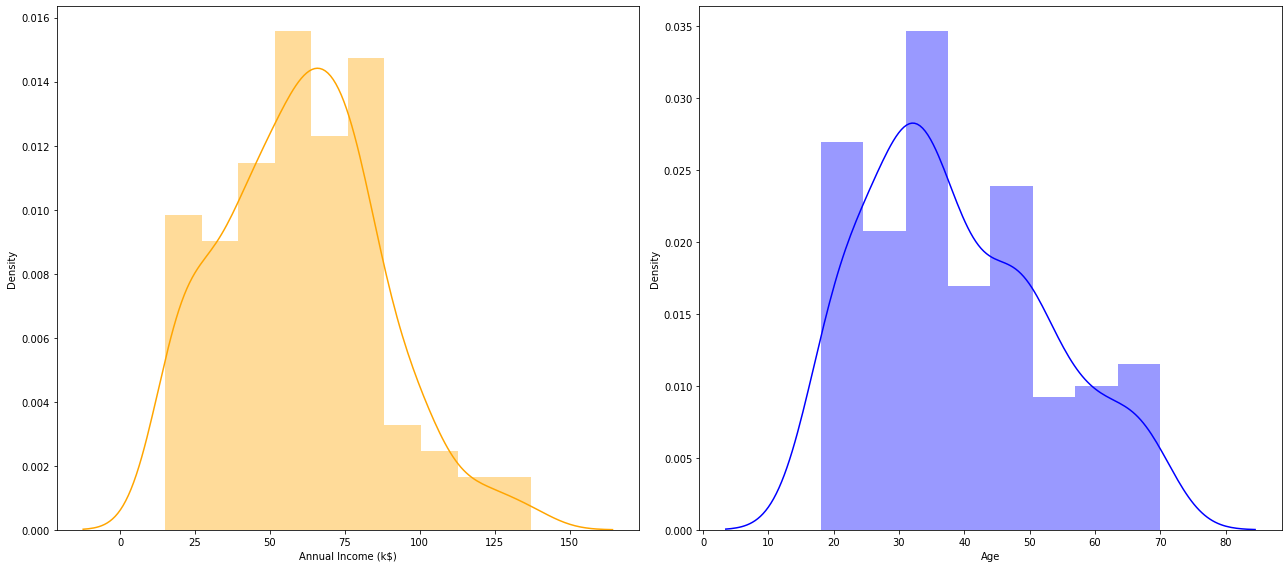

In [5]:
plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
sns.distplot(data['Annual Income (k$)'], color='orange')

plt.subplot(1,2,2)
# TODO: plot the age distribution
sns.distplot(data['Age'], color='blue')
plt.tight_layout()

### **3. Data Normalization [5 points]**

As features are in various ranges,  the difference of different features can be in different scales. For example, for the first two data points, the *Spending Score* difference is $|39-81| = 42$, and the *gender* difference is $1$. If the distance is calculated directly on the raw features, the distance is more influenced by the former feature. However, we do not assume *Spending Score* is more impactful than *gender* in deciding distance between data points. Therefore, data normalization is necessary to transform data into the same scale of range.

One common way to normalize data is to transform each feature into a range $[0, 1]$, i.e., for feature $i$:

$$\hat{X}_i = \frac{X_i - X_i^{min}}{X_i^{max} - X_i^{min}}$$

where $X_i$ is the $i$(th) feature value of data point $X$. $X_i^{min}, X_i^{max}$ are the minimum and maximum of data points of the $i$(th) feature. This function is implemented in the **sklearn** package and can be used by ` data_tx=MinMaxScaler().fit_transform(data)`

In this assignment, however, we will have data normalization with another very commonly used scaler, **Standard Scaler** and it is computed as:

$$\hat{X}_i = \frac{X_i - X_i^{\mu}}{X_i^\sigma}$$
where $X_i^{\mu}, X_i^{\sigma}$ are the mean value and derivation value of the $i$(th) feature.

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

In [7]:
def data_norm(data):
    # TODO: use the StandardScaler function from the package or implement it from scratch to transform the data
    # data_t = MinMaxScaler().fit_transform(data)
    data_t = StandardScaler().fit_transform(data)
    return data_t

In [8]:
data_tx = data_norm(data)

In [9]:
def test_normalization(data_tx):
    assert np.abs(data_tx[0, 0] - -1.4245) < 1e-3
    print('Pass: Data Normalization [5 points]')
test_normalization(data_tx)

Pass: Data Normalization [5 points]


### **3. K-Means**

Now we will break down the KMeans algorithm and implement it. The KMeans algorithm can be decomposed into three stages:
1. Randomly select $K$ data points as the initial centroids of $K$ clusters, respectively.
2. For each data points, assign it to its closest cluster.
3. Update the centroid of each cluster with the assigned points.
Repeat 2 and 3 until no point moves anymore.

#### **3.1 Randomly select $K$ data points** [0 points]
For the purpose of repeatability, we set the random seed and want to randomly select $K$ index values from the $N$ data points

In [10]:
def select_K_points(N, K):
    np.random.seed(1)
    array = []
    # Done: randomly select K points using the np.random.randint() function
    for i in range(K):
        idx = np.random.randint(0, N)
        array.append(idx)
    array = np.array(array)
    return array

In [11]:
def test_select_K():
    array = select_K_points(5, 3)
    assert list(array) == [3, 4, 0]
    print('Pass: Random selection [0 points]')
test_select_K()

Pass: Random selection [0 points]


#### **3.2 Randomly select $K$ data points** [20 points]
In the second step, assume we have $K$ clusters, each having its own centroid. K-Means algorithm assigns each data point a cluster label. Each data point is assigned to its closest cluster by taking the one having the shortest distance to the centroids.

In [12]:
def distance(u, v):
    dist = np.square(np.sum((u - v)**2))
    return dist

# TODO: return the assignment of all nodes
# data is of shape (N, d), representing N points, each of d dimensions
# centers is of shape (K, d), representing K centroids, each of d dimensions
def assign_nodes(data, centers):
    N, d = data.shape
    cluster_of_nodes = np.zeros(N)
    for i in range(N):
      cluster_of_nodes[i] = np.argmin([distance(data[i], centers[k]) for k in range(len(centers))])
    return cluster_of_nodes

In [13]:
def test_assign_nodes():
    data = np.array(
        [
            [1, 1],
            [1, 3],
            [3, 1],
            [3, 3],
            [5, 5],
            [5, 7],
            [7, 5],
            [7, 7]
        ]
    )
    centers = np.array([[2, 2], [6, 6]])
    assignment = assign_nodes(data, centers)
    assert list(assignment) == [0., 0., 0., 0., 1., 1, 1., 1.]
    print('Pass: Assign nodes to clusters [20 points]')
test_assign_nodes()

Pass: Assign nodes to clusters [20 points]


#### **3.3 Recalculate the centroids** [20 points]
In the third step, we have the assignments of all data points. K-Means calculates the centroid for each cluster.

In [14]:
# TODO: caluclate the centroid of each cluster
# cluster_of_nodes is a list of N elements, each represents the assigned label of a data point
def calculate_centroids(cluster_of_nodes, data, K):
    N, d = data.shape
    cluster_centers = np.zeros([K, d])
    cluster_of_nodes = np.array(cluster_of_nodes)
    for k in range(K):
      # print(data[np.where(cluster_of_nodes==k)])
      # print(np.where(cluster_of_nodes==k)[0])
      cluster_centers[k] = np.sum(data[np.where(cluster_of_nodes==k)], axis=0)/len(np.where(cluster_of_nodes==k)[0])
    return cluster_centers


In [15]:
def test_calculate_centroids():
    cluster_of_nodes = [0., 0., 0., 0., 1., 1, 1., 1.]
    data = np.array(
        [
            [1, 1],
            [1, 3],
            [3, 1],
            [3, 3],
            [5, 5],
            [5, 7],
            [7, 5],
            [7, 7]
        ]
    )
    K = 2
    cluster_centers = calculate_centroids(cluster_of_nodes, data, K)
    assert list(cluster_centers.flatten()) == [2, 2, 6, 6]
    print('Pass: Calculate centroids [20 points]')
test_calculate_centroids()

Pass: Calculate centroids [20 points]


In [16]:
class MyKMeans:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
    
    # data ~ [N, d]: N samples, d dimensions
    
    def fit(self, data):
        N, d = data.shape
        # step 1: Random initialization
        random_idxs = select_K_points(N, num_clusters)
        self.cluster_centers = data[random_idxs]

        # step 2: Assign nodes
        cluster_of_nodes = assign_nodes(data, self.cluster_centers)
        
        # step 3: Recalculate centroids.
        self.new_cluster_centers = calculate_centroids(cluster_of_nodes, data, self.num_clusters)
        
        # TODO: Repeat step 2 and 3 until convergence or count reach a maximum of 100 times. [40 points]
        count = 0
        max_count = 100
        while count < max_count:
          if (self.cluster_centers == self.new_cluster_centers).all():
            break
          self.cluster_centers = self.new_cluster_centers
          # step 2: Assign nodes
          cluster_of_nodes = assign_nodes(data, self.cluster_centers)
          # step 3: Recalculate centroids.
          self.new_cluster_centers = calculate_centroids(cluster_of_nodes, data, self.num_clusters)
          count += 1
        self.cluster_centers = self.new_cluster_centers
        
    def assign(self, data):
        cluster_of_nodes = assign_nodes(data, self.cluster_centers)
        return cluster_of_nodes

In [17]:
num_clusters = 5

km = MyKMeans(num_clusters)
km.fit(data_tx)

In [18]:
clusters=km.assign(data_tx)

In [19]:
clusters

array([0., 3., 0., 0., 0., 0., 0., 0., 2., 0., 2., 0., 2., 0., 2., 3., 0.,
       3., 2., 0., 3., 3., 2., 3., 2., 3., 2., 3., 0., 0., 2., 0., 2., 3.,
       2., 0., 2., 0., 0., 0., 2., 3., 2., 0., 2., 0., 2., 0., 0., 0., 2.,
       3., 0., 2., 2., 2., 2., 2., 0., 2., 2., 3., 2., 2., 2., 3., 2., 2.,
       3., 0., 2., 2., 2., 2., 2., 3., 2., 3., 0., 2., 2., 3., 2., 2., 0.,
       2., 2., 4., 4., 2., 2., 3., 2., 4., 4., 3., 2., 4., 2., 3., 4., 2.,
       2., 3., 2., 4., 2., 2., 2., 2., 2., 4., 4., 3., 4., 4., 2., 2., 2.,
       2., 3., 4., 4., 3., 4., 4., 1., 3., 1., 3., 1., 3., 4., 4., 1., 4.,
       1., 3., 1., 4., 1., 3., 4., 4., 1., 3., 1., 4., 1., 3., 1., 3., 1.,
       4., 1., 4., 1., 4., 1., 4., 2., 4., 1., 4., 1., 4., 1., 4., 1., 3.,
       1., 3., 1., 3., 1., 4., 1., 3., 1., 3., 1., 4., 1., 4., 1., 3., 1.,
       3., 1., 4., 1., 4., 1., 4., 1., 4., 1., 3., 1., 3.])

#### **4 Visualizing Clustering Result**
To visualize clustering result in a 2-D space, we have to reduce the dimension of data. In this assignment, we use *Principle Component Analysis* to reduce the number of dimensions. Your clustering result should result a visualization of 5 obvious clusters

In [20]:
pca=PCA(n_components=2)
reduced_data=pca.fit_transform(data_tx)

In [21]:
reduced_data=pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_data['clusters']=clusters

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

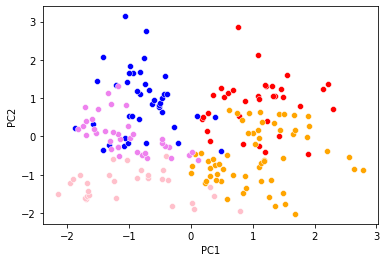

In [22]:
plt.figure(figsize=(6,4))
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==0, 'PC1'], reduced_data.loc[reduced_data['clusters']==0, 'PC2'],color='pink')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==1, 'PC1'], reduced_data.loc[reduced_data['clusters']==1, 'PC2'],color='red')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==2, 'PC1'], reduced_data.loc[reduced_data['clusters']==2, 'PC2'],color='orange')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==3, 'PC1'], reduced_data.loc[reduced_data['clusters']==3, 'PC2'],color='blue')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==4, 'PC1'], reduced_data.loc[reduced_data['clusters']==4, 'PC2'],color='violet')

plt.show()

#### **4.1 Visualization through T-SNE** [10 points]
Similarly, we can visualize data with other dimension reduction algorithms. Fill up the following code cell to visualize the data from the dimension reduction result of TSNE.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning

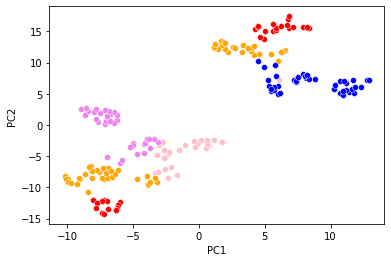

In [23]:
from sklearn.manifold import TSNE

# TODO: similar to the code of PCA, reduce the data dimension with TSNE
tsne = TSNE(n_components=2)
reduced_data=tsne.fit_transform(data_tx)

reduced_data=pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_data['clusters']=clusters

plt.figure(figsize=(6,4))
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==0, 'PC1'], reduced_data.loc[reduced_data['clusters']==0, 'PC2'],color='pink')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==1, 'PC1'], reduced_data.loc[reduced_data['clusters']==1, 'PC2'],color='red')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==2, 'PC1'], reduced_data.loc[reduced_data['clusters']==2, 'PC2'],color='orange')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==3, 'PC1'], reduced_data.loc[reduced_data['clusters']==3, 'PC2'],color='blue')
sns.scatterplot(reduced_data.loc[reduced_data['clusters']==4, 'PC1'], reduced_data.loc[reduced_data['clusters']==4, 'PC2'],color='violet')

plt.show()